# Requirments

## Import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
PATH = './drive/MyDrive/datasets/'

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/groom_project2
%pwd

/content/drive/MyDrive/groom_project2


'/content/drive/MyDrive/groom_project2'

In [ ]:
!pip install transformers wandb torchinfo

     |████████████████████████████████| 4.0 MB 14.7 MB/s 
     |████████████████████████████████| 1.8 MB 83.1 MB/s 
     |████████████████████████████████| 6.6 MB 62.4 MB/s 
     |████████████████████████████████| 895 kB 92.3 MB/s 
     |████████████████████████████████| 596 kB 88.7 MB/s 
     |████████████████████████████████| 77 kB 8.9 MB/s 
     |████████████████████████████████| 181 kB 93.9 MB/s 
     |████████████████████████████████| 144 kB 90.5 MB/s 
     |████████████████████████████████| 63 kB 2.3 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=b890c7b819dad59672f858bf53c279158ee5ded6d8b116021bdb01d5b50117ec
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import os
import random
import math
import csv
import json
from statistics import mean
from typing import List, Tuple, Dict, Any
import uuid

from tqdm.notebook import tqdm
from easydict import EasyDict as edict

import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import wandb

import torch
from torch.utils.data import DataLoader
from torch.nn.utils import clip_grad_norm_
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F

from torchinfo import summary

from transformers import ElectraModel, ElectraTokenizer, ElectraForQuestionAnswering, AutoModelForQuestionAnswering, AutoTokenizer

In [ ]:
for name in 'models', 'submissions':
    os.makedirs(name, exist_ok=True)

# Set Arguments, Hyper-parameters

In [ ]:
args = edict({'w_project': 'test_project',
              'w_entity': 'lukass',
              'learning_rate': 6e-5,
              'batch_size': {'train': 64,
                             'eval': 4,
                             'test': 256},
              'accumulate': 32,
              'epochs': 2,
              'seed': 42,
              # 'model_name': 'monologg/koelectra-base-v3-discriminator',
              'model_name': 'monologg/kobigbird-bert-base',
              'max_length': 1024})
# args['NAME'] = ''f'koelectra_ep{args.epochs}_lr{args.learning_rate}_{random.randrange(0, 1024)}'
args['NAME'] = ''f'kobigbird_v2_ep{args.epochs}_max{args.max_length}_lr{args.learning_rate}_{random.randrange(0, 1024)}'
print(args.NAME)

kobigbird_v2_ep2_max1024_lr6e-05_947


# Initialize

## Wandb

In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
wandb.init(project = args.w_project, entity = args.w_entity)

wandb: Currently logged in as: goorm_team_2 (use `wandb login --relogin` to force relogin)


In [ ]:
wandb.run.name = args.NAME
wandb.config.learning_rate = args.learning_rate
wandb.config.epochs = args.epochs
wandb.config.batch_size = args.batch_size

## Seed

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore

seed_everything(args.seed)

## Tokenizer

In [ ]:
# tokenizer = ElectraTokenizer.from_pretrained(args.model_name)
tokenizer = AutoTokenizer.from_pretrained(args.model_name)

Downloading:   0%|          | 0.00/373 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/236k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/480k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/169 [00:00<?, ?B/s]

## Model

In [ ]:
# model = ElectraForQuestionAnswering.from_pretrained(args.model_name)
model = AutoModelForQuestionAnswering.from_pretrained(args.model_name)
# summary(model, (args.batch_size.train//args.accumulate, args.max_length), dtypes=['torch.IntTensor'], device='cpu')

Downloading:   0%|          | 0.00/870 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at monologg/kobigbird-bert-base were not used when initializing BigBirdForQuestionAnswering: ['bert.pooler.weight', 'bert.pooler.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BigBirdForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BigBirdForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of 

In [ ]:
model.cuda();

## Optimizer

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=args.learning_rate)

# Datasets

## Load, Split

In [ ]:
class KoMRC:
    def __init__(self, data, indices: List[Tuple[int, int, int]]):
        self._data = data
        self._indices = indices


    # Json을 불러오는 메소드
    @classmethod
    def load(cls, file_path: str):
        with open(file_path, 'r', encoding='utf-8') as fd:
            data = json.load(fd)

        indices = []
        for d_id, document in enumerate(data['data']):
            for p_id, paragraph in enumerate(document['paragraphs']):
                for q_id, _ in enumerate(paragraph['qas']):
                    indices.append((d_id, p_id, q_id))
        
        return cls(data, indices)

    # Json을 불러오는 메소드
    @classmethod
    def loads(cls, *file_path: str):
        datas = {'data': []}
        indices = []
        
        for f in file_path:
            with open(f, 'r', encoding='utf-8') as fd:
                data = json.load(fd)
            datas['data'] += data['data']
            
        for d_id, document in enumerate(datas['data']):
            for p_id, paragraph in enumerate(document['paragraphs']):
                for q_id, _ in enumerate(paragraph['qas']):
                    indices.append((d_id, p_id, q_id))

        return cls(datas, indices)

    # 데이터 셋을 잘라내는 메소드
    @classmethod
    def split(cls, dataset, eval_ratio: float=.016108):
        indices = list(dataset._indices)
        random.shuffle(indices)
        train_indices = indices[int(len(indices) * eval_ratio):]
        eval_indices = indices[:int(len(indices) * eval_ratio)]

        return cls(dataset._data, train_indices), cls(dataset._data, eval_indices)


    def __getitem__(self, index: int) -> Dict[str, Any]:
        d_id, p_id, q_id = self._indices[index]
        paragraph = self._data['data'][d_id]['paragraphs'][p_id]

        qa = paragraph['qas'][q_id]

        if 'guid' in qa:
            guid = qa['guid']
        else:
            guid = uuid.uuid4().hex

        context = paragraph['context'].replace('\n', 'n').replace('\xad', ' ').replace('\xa0', ' ').replace('\u200b', ' ')

        question = qa['question'].replace('\n', 'n').replace('\xad', ' ').replace('\xa0', ' ').replace('\u200b', ' ')

        answers = qa['answers']
        if answers != None:
            for a in answers:
                a['text'] = a['text'].replace('\n', 'n').replace('\xad', ' ').replace('\xa0', ' ').replace('\u200b', ' ')
        else:
            answers = None


        return {'guid': guid,
            'context': context,
            'question': question,
            'answers': answers
        }

    def __len__(self) -> int:
        return len(self._indices)

In [ ]:
dataset1 = KoMRC.load('./datasets2/train.json')
dataset2 = KoMRC.load('./datasets2/ko_nia_normal_squad_all.json')
dataset3 = KoMRC.load('./datasets2/ko_wiki_v1_squad.json')
print("Number of Samples:", len(dataset1), len(dataset2), len(dataset3))

Number of Samples: 12037 243425 100268


## Tokenize & Tag Token Positions

In [ ]:
class TokenizedKoMRC(KoMRC):
    def __init__(self, data, indices: List[Tuple[int, int, int]]) -> None:
        super().__init__(data, indices)
        self._tokenizer = tokenizer


    def _tokenize_with_position(self, sentence: str) -> List[Tuple[str, Tuple[int, int]]]:
        position = 0
        tokens = []

        sentence_tokens = []
        for word in sentence.split():
            if '[UNK]' in tokenizer.tokenize(word):
                sentence_tokens.append(word)
            else:
                sentence_tokens += tokenizer.tokenize(word)
        
        for morph in sentence_tokens:
            if len(morph) > 2:
                if morph[:2] == '##':
                    morph = morph[2:]

            position = sentence.find(morph, position)
            tokens.append((morph, (position, position + len(morph))))
            position += len(morph)
            
        return tokens
            

    def __getitem__(self, index: int) -> Dict[str, Any]:
        sample = super().__getitem__(index)
        # sample = {'guid': guid, 'context': context, 'question': question, 'answers': answers}

        context, position = zip(*self._tokenize_with_position(sample['context']))
        context, position = list(context), list(position)

        question = self._tokenizer.tokenize(sample['question'])

        if sample['answers'] is not None:
            answers = []
            for answer in sample['answers']:
                for start, (position_start, position_end) in enumerate(position):
                    if position_start <= answer['answer_start'] < position_end:
                        break
                else:
                    print(context, answer)
                    print(answer['guid'])
                    print(answer['answer_start'])
                    raise ValueError("No mathced start position")

                target = ''.join(answer['text'].split(' '))
                source = ''
                for end, morph in enumerate(context[start:], start):
                    source += morph
                    if target in source:
                        break
                else:
                    print(context, answer)
                    print(answer['guid'])
                    print(answer['answer_start'])
                    raise ValueError("No Matched end position")

                answers.append({'start': start, 'end': end})

        else:
            answers = None
        
        return {
            'guid': sample['guid'],
            'context_original': sample['context'],
            'context_position': position,
            'question_original': sample['question'],
            'context': context,
            'question': question,
            'answers': answers,
            'answers_text': sample['answers'][0]['text']
        }

In [ ]:
dataset = TokenizedKoMRC.loads('./datasets2/train.json', './datasets2/ko_nia_normal_squad_all.json', './datasets2/ko_wiki_v1_squad.json')
train_dataset, dev_dataset = TokenizedKoMRC.split(dataset)

dev_answers = [dev_dataset[i]['answers_text'] for i in range(len(dev_dataset))]

print("Number of Train Samples:", len(train_dataset))
print("Number of Dev Samples:", len(dev_dataset))
# print(sample['context'][sample['answers'][0]['start']:sample['answers'][0]['end']+1])

Number of Train Samples: 350000
Number of Dev Samples: 5730


## Input

In [ ]:
class Indexer:
    def __init__(self, vocabs: List[str], max_length: int=args.max_length):
        self.max_length = max_length
        self.vocabs = vocabs

    @property
    def vocab_size(self):
        return len(self.vocabs)
    @property
    def pad_id(self):
        return tokenizer.vocab['[PAD]']
    @property
    def unk_id(self):
        return tokenizer.vocab['[UNK]']
    @property
    def cls_id(self):
        return tokenizer.vocab['[CLS]']
    @property
    def sep_id(self):
        return tokenizer.vocab['[SEP]']


    def sample2ids(self, sample: Dict[str, Any],) -> Dict[str, Any]:
        context = [tokenizer.convert_tokens_to_ids(token) for token in sample['context']]
        question = [tokenizer.convert_tokens_to_ids(token) for token in sample['question']]

        context = context[:self.max_length-len(question)-3]             # Truncate context
        
        input_ids = [self.cls_id] + question + [self.sep_id] + context + [self.sep_id]
        token_type_ids = [0] * (len(question) + 1) + [1] * (len(context) + 2)

        if sample['answers'] is not None:
            answer = sample['answers'][0]
            start = min(len(question) + 2 + answer['start'], self.max_length - 1)
            end = min(len(question) + 2 + answer['end'], self.max_length - 1)
        else:
            start = None
            end = None

        return {
            'guid': sample['guid'],
            'context': sample['context_original'],
            'question': sample['question_original'],
            'position': sample['context_position'],
            'input_ids': input_ids,
            'token_type_ids': token_type_ids,
            'start': start,
            'end': end
        }

In [ ]:
indexer = Indexer(list(tokenizer.vocab.keys()))

## Attention Mask

In [ ]:
class IndexerWrappedDataset:
    def __init__(self, dataset: TokenizedKoMRC, indexer: Indexer) -> None:
        self._dataset = dataset
        self._indexer = indexer

    def __len__(self) -> int:
        return len(self._dataset)
    
    def __getitem__(self, index: int) -> Dict[str, Any]:
        sample = self._indexer.sample2ids(self._dataset[index])
        sample['attention_mask'] = [1] * len(sample['input_ids'])

        return sample

In [ ]:
indexed_train_dataset = IndexerWrappedDataset(train_dataset, indexer)
indexed_dev_dataset = IndexerWrappedDataset(dev_dataset, indexer)

## Collate

In [ ]:
class Collator:
    def __init__(self, indexer: Indexer) -> None:
        self._indexer = indexer


    def __call__(self, samples: List[Dict[str, Any]]) -> Dict[str, torch.Tensor]:
        samples = {key: [sample[key] for sample in samples] for key in samples[0]}

        for key in 'start', 'end':
            if samples[key][0] is None:
                samples[key] = None
            else:
                samples[key] = torch.tensor(samples[key], dtype=torch.long)
        
        for key in 'input_ids', 'attention_mask', 'token_type_ids':
            samples[key] = pad_sequence([torch.tensor(sample, dtype=torch.long) for sample in samples[key]],
                                        batch_first=True,
                                        padding_value=self._indexer.pad_id)

        return samples

## Data Loader

In [ ]:
collator = Collator(indexer)
train_loader = DataLoader(indexed_train_dataset,
                          batch_size = args.batch_size.train // args.accumulate,
                          shuffle = True,
                          collate_fn = collator,
                          num_workers = 2)

dev_loader = DataLoader(indexed_dev_dataset,
                        batch_size = args.batch_size.eval,
                        shuffle = False,
                        collate_fn = collator,
                        num_workers = 2)

In [ ]:
batch = next(iter(train_loader))
batch = next(iter(dev_loader))
# print(batch['input_ids'])
# print(batch['input_ids'].shape)
# print(list(batch.keys()))

# Train

## Empty Cuda Cache

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

## Train

In [ ]:
train_losses = []
dev_losses = []

train_loss = []
dev_loss = []

loss_accumulate = 0.

best_model = [-1, int(1e9)]

for epoch in range(args.epochs):
    print("Epoch", epoch, '===============================================================================================================')

    # Train    
    progress_bar_train = tqdm(train_loader, desc='Train')
    for i, batch in enumerate(progress_bar_train, 1):
        del batch['guid'], batch['context'], batch['question'], batch['position']
        batch = {key: value.cuda() for key, value in batch.items()}
        
        start = batch.pop('start')
        end = batch.pop('end')
        
        output = model(**batch)

        start_logits = output.start_logits
        end_logits = output.end_logits
        
        loss = (F.cross_entropy(start_logits, start) + F.cross_entropy(end_logits, end)) / args.accumulate
        loss.backward()

        loss_accumulate += loss.item()

        del batch, start, end, start_logits, end_logits, loss
        
        if i % args.accumulate == 0:
            # clip_grad_norm_(model.parameters(), max_norm=1.)
            optimizer.step()
            optimizer.zero_grad(set_to_none=False)

            train_loss.append(loss_accumulate)
            progress_bar_train.set_description(f"Train - Loss: {loss_accumulate:.3f}")
            loss_accumulate = 0.
        else:
            continue

        if i % int(len(train_loader) / (args.accumulate * 50)) == 0:
            # Evaluation
            for batch in dev_loader:
                del batch['guid'], batch['context'], batch['question'], batch['position']
                batch = {key: value.cuda() for key, value in batch.items()}

                start = batch.pop('start')
                end = batch.pop('end')
                
                model.eval()
                with torch.no_grad():
                    output = model(**batch)
                
                    start_logits = output.start_logits
                    end_logits = output.end_logits
                model.train()

                loss = F.cross_entropy(start_logits, start) + F.cross_entropy(end_logits, end)

                dev_loss.append(loss.item())

                del batch, start, end, start_logits, end_logits, loss

            train_losses.append(mean(train_loss))
            dev_losses.append(mean(dev_loss))
            train_loss = []
            dev_loss = []

            
            if dev_losses[-1] <= best_model[1]:
                best_model = (epoch, dev_losses[-1])
                model.save_pretrained(f'models/{args.NAME}_{epoch}')
                
            wandb.log({"train_loss": train_losses[-1], 
                       "valid_loss": dev_losses[-1]})
            
    print(f"Train Loss: {train_losses[-1]:.3f}")
    print(f"Valid Loss: {dev_losses[-1]:.3f}")
    print('- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -')


Epoch 0 ===============================================================================================================


Train:   0%|          | 0/175000 [00:00<?, ?it/s]

Attention type 'block_sparse' is not possible if sequence_length: 471 <= num global tokens: 2 * config.block_size + min. num sliding tokens: 3 * config.block_size + config.num_random_blocks * config.block_size + additional buffer: config.num_random_blocks * config.block_size = 704 with config.block_size = 64, config.num_random_blocks = 3. Changing attention type to 'original_full'...


Train Loss: 1.536
Valid Loss: 1.440
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Epoch 1 ===============================================================================================================


Train:   0%|          | 0/175000 [00:00<?, ?it/s]

Train Loss: 1.331
Valid Loss: 1.424
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


## Visualize Training

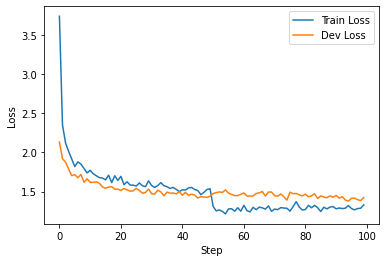

In [ ]:
plt.plot(train_losses, label="Train Loss")
plt.plot(dev_losses, label="Dev Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Test

## Datasets

In [ ]:
test_dataset = TokenizedKoMRC.load('./datasets2/test.json')
indexer_test = Indexer(list(tokenizer.vocab.keys()))
indexed_test_dataset = IndexerWrappedDataset(test_dataset, indexer_test)
print("Number of Test Samples", len(test_dataset))
# print(test_dataset[0])

Number of Test Samples 4008


## Model

In [ ]:
best_model[0]

1

In [ ]:
model = AutoModelForQuestionAnswering.from_pretrained(f'models/{args.NAME}_{best_model[0]}')
model.cuda();
# summary(model, (args.batch_size.train//args.accumulate, args.max_length), dtypes=['torch.IntTensor'], device='cpu')

In [ ]:
for idx, sample in zip(range(1, 4), indexed_train_dataset):
    print(f'------{idx}------')
    print('Context:', sample['context'])
    print('Question:', sample['question'])
    
    input_ids, token_type_ids = [
        torch.tensor(sample[key], dtype=torch.long, device="cuda")
        for key in ("input_ids", "token_type_ids")
    ]
    
    model.eval()
    with torch.no_grad():
        output = model(input_ids=input_ids[None, :], token_type_ids=token_type_ids[None, :])

    start_logits = output.start_logits
    end_logits = output.end_logits
    start_logits.squeeze_(0), end_logits.squeeze_(0)
    
    start_prob = start_logits[token_type_ids.bool()][1:-1].softmax(-1)
    end_prob = end_logits[token_type_ids.bool()][1:-1].softmax(-1)

    probability = torch.triu(start_prob[:, None] @ end_prob[None, :])

    index = torch.argmax(probability).item()
    
    start = index // len(end_prob)
    end = index % len(end_prob)
    
    start_str = sample['position'][start][0]
    end_str = sample['position'][end][1]

    print('Answer:', sample['context'][start_str:end_str])

Attention type 'block_sparse' is not possible if sequence_length: 422 <= num global tokens: 2 * config.block_size + min. num sliding tokens: 3 * config.block_size + config.num_random_blocks * config.block_size + additional buffer: config.num_random_blocks * config.block_size = 704 with config.block_size = 64, config.num_random_blocks = 3. Changing attention type to 'original_full'...


------1------
Context: 국내 의료진이 개발해 ‘척추체간 케이지’가 미국과 중국에서도 신기술 가치를 인정받아 특허로 등록됐다. 강동경희대병원은 신경외과 조대진(사진) 교수가 지난 2016년 개발, 국내 특허를 취득한 척추체간 케이지를 최근 중국과 미국에도 특허를 출원, 각각 허가를 받는데 성공했다고 18일 밝혔다. 조 교수는 이를 중국과 미국에 각각 수출할 계획이다. 이 척추체간 케이지는 ‘추체간 유합술에 사용되는 인공디스크의 일종이다. 추체간 유합술은 퇴행성 척추질환으로 수술이 필요한 경우, 디스크를 제거해 그 자리에 ‘케이지’와 같은 인공 디스크를 삽입, 뼈가 붙도록 하는 수술법이다. 조 교수가 이번에 국제특허를 획득한 케이지(2 GatherⓇ)는 척추수술 시 척추의 정면, 후면, 측면 방향에서 자유롭게 장착할 수 있도록 고안된 기구다. 전방용, 후방용, 측방용 등으로 각각 구분돼 있던 기존 케이지를 조 교수가 하나로 통합해 효용성을 높였다. 국내에서는 특허등록 후 작년부터 상용화됐다. 조 교수는 미국과 중국 특허권을 경희대학교 산학협력단에 기부할 계획이다. 조 교수는 “새 척추체간 케이지를 이용, 보다 많은 척추질환자들이 삶의 질 개선 효과를 보길 바란다”고 말했다. 조 교수는 척추변형 및 척추재수술에 있어 우수 수술결과 및 새로운 수술법 개발로 40여 편에 가까운 논문을 국제학술지 SCI(E)에 발표해 국내 뿐 아니라 해외에서도 주목받고 있다. 이기수 의학전문기자 kslee@kmib.co.kr
Question: 국내 의료진이 개발한 ‘척추체간 케이지’가 어디에서도 신기술 가치를 인정받아 특허로 등록됐어?
Answer: 미국과 중국
------2------
Context: 홈 키 및 엔드 키의 유래는 수동식 타자기에서 종이를 세팅하는 롤러부분을 수동으로 좌우로 움직여야했던 조작에서 온 것이다. 롤러(종이)를 오른쪽으로 움직이면 종이의 왼쪽에 타자장치가 온다. 왼쪽으로 옮기면 오른쪽에 타자장치가 온다. 또 이 조작에선 개행(종이를 위로 이동

In [ ]:
## evaluate valid

In [ ]:
start_visualize = []
end_visualize = []

dev_prediction = []
# for sample in tqdm(test_dataset, "Testing"):
for sample in tqdm(indexed_dev_dataset, "Testing"):
    input_ids, token_type_ids = [torch.tensor(sample[key], dtype=torch.long, device="cuda") for key in ("input_ids", "token_type_ids")]
    # print(sample)

    model.eval()
    with torch.no_grad():
        output = model(input_ids=input_ids[None, :], token_type_ids=token_type_ids[None, :])

    start_logits = output.start_logits
    end_logits = output.end_logits
    start_logits.squeeze_(0), end_logits.squeeze_(0)

    start_prob = start_logits[token_type_ids.bool()][1:-1].softmax(-1)
    end_prob = end_logits[token_type_ids.bool()][1:-1].softmax(-1)

    probability = torch.triu(start_prob[:, None] @ end_prob[None, :])

    # 토큰 길이 8까지만
    for row in range(len(start_prob) - 8):
        probability[row] = torch.cat((probability[row][:8+row].cpu(), torch.Tensor([0] * (len(start_prob)-(8+row))).cpu()), 0)

    index = torch.argmax(probability).item()

    start = index // len(end_prob)
    end = index % len(end_prob)

    # 확률 너무 낮으면 자르기
    if start_prob[start] >= 0 or end_prob[end] >= 0:
        start_str = sample['position'][start][0]
        end_str = sample['position'][end][1]
    else:
        start_str = 0
        end_str = 0

    start_visualize.append((list(start_prob.cpu()), (start, end), (start_str, end_str)))
    end_visualize.append((list(end_prob.cpu()), (start, end), (start_str, end_str)))

    dev_prediction.append([sample["guid"], sample['context'][start_str:end_str]])


In [ ]:
## Lenvenshtein

In [ ]:
def calc_distance(a, b):
    ''' 레벤슈타인 거리 계산하기 '''
    if a == b:
        return 0 # 같으면 0을 반환
    
    a_len = len(a) # a 길이
    b_len = len(b) # b 길이
    if a == "":
        return b_len
    if b == "":
        return a_len
    
    matrix = [[] for i in range(a_len+1)]
    
    for i in range(a_len+1): # 0으로 초기화
        matrix[i] = [0 for j in range(b_len+1)]
        
    # 0일 때 초깃값을 설정
    for i in range(a_len+1):
        matrix[i][0] = i
        
    for j in range(b_len+1):
        matrix[0][j] = j
        
    # 표 채우기 --- (※2)
    for i in range(1, a_len+1):
        ac = a[i-1]
        for j in range(1, b_len+1):
            bc = b[j-1]
            cost = 0 if (ac == bc) else 1
            matrix[i][j] = min([
                matrix[i-1][j] + 1,     # 문자 삽입
                matrix[i][j-1] + 1,     # 문자 제거
                matrix[i-1][j-1] + cost # 문자 변경
            ])
            
    return matrix[a_len][b_len]

In [ ]:
score = []
for i in range(int(len(dev_answers))):
    s = calc_distance(dev_prediction[i], dev_answers[i][0])
    score.append(s)
mean(score)

1.974869109947644

## Evaluate

In [ ]:
start_visualize = []
end_visualize = []

with torch.no_grad(), open(f'submissions/{args.NAME}.csv', 'w') as fd:
    writer = csv.writer(fd)
    writer.writerow(['Id', 'Predicted'])

    rows = []
    # for sample in tqdm(test_dataset, "Testing"):
    for sample in tqdm(indexed_test_dataset, "Testing"):
        input_ids, token_type_ids = [torch.tensor(sample[key], dtype=torch.long, device="cuda") for key in ("input_ids", "token_type_ids")]
        # print(sample)
    
        model.eval()
        with torch.no_grad():
            output = model(input_ids=input_ids[None, :], token_type_ids=token_type_ids[None, :])

        start_logits = output.start_logits
        end_logits = output.end_logits
        start_logits.squeeze_(0), end_logits.squeeze_(0)

        start_prob = start_logits[token_type_ids.bool()][1:-1].softmax(-1)
        end_prob = end_logits[token_type_ids.bool()][1:-1].softmax(-1)

        probability = torch.triu(start_prob[:, None] @ end_prob[None, :])

        # 토큰 길이 8까지만
        for row in range(len(start_prob) - 8):
            probability[row] = torch.cat((probability[row][:8+row].cpu(), torch.Tensor([0] * (len(start_prob)-(8+row))).cpu()), 0)

        index = torch.argmax(probability).item()

        start = index // len(end_prob)
        end = index % len(end_prob)
        
        # 확률 너무 낮으면 자르기
        if start_prob[start] >= 0 or end_prob[end] >= 0:
            start_str = sample['position'][start][0]
            end_str = sample['position'][end][1]
        else:
            start_str = 0
            end_str = 0

        start_visualize.append((list(start_prob.cpu()), (start, end), (start_str, end_str)))
        end_visualize.append((list(end_prob.cpu()), (start, end), (start_str, end_str)))
        
        rows.append([sample["guid"], sample['context'][start_str:end_str]])

    writer.writerows(rows)

Testing:   0%|          | 0/4008 [00:00<?, ?it/s]

TypeError: ignored